In [1]:
import torch
import torch.nn as nn
from torch.optim import Optimizer

In [284]:
%pip install -U wandb

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import wandb

In [4]:
wandb.login(key=input('api key: '))

api key:  61a3313d2641a6255db43ddd325965697d9ab89b


wandb: Currently logged in as: unqrf (unqrf-sirius-ec-team). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jupyter/.netrc


True

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
class Model(nn.Module):
    def __init__(self, hidden_size):
        super(Model, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x, t):
        return self.model(torch.stack((x,t),dim=1)).flatten()

In [9]:
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
from tqdm import tqdm
from IPython.display import clear_output
import numpy as np

In [11]:
class CustomDataset(Dataset):
    def __init__(self, t, x, u):
        super(CustomDataset).__init__()
        self.t = t
        self.x = x
        self.u = u

    def __len__(self):
        return len(self.t)

    def __getitem__(self, item):
        return (self.t[item], self.x[item], self.u[item])
        
from random import randint

samples_cnt = 10000
T, X, U = [], [], []
for i in range(samples_cnt):
    tp = randint(0,5)
    if tp==0:
        T.append(torch.rand(1))
        X.append(torch.rand(1)*2-1)
        U.append(torch.nan)
    if tp==1:
        Xval = torch.rand(1) * 2 - 1
        T.append(torch.tensor(0))
        X.append(Xval)
        U.append(torch.Tensor(-torch.sin(torch.pi * Xval)))
    if tp==2:
        T.append(torch.rand(1))
        X.append(torch.tensor(1))
        U.append(torch.tensor(0))
    if tp==3:
        T.append(torch.rand(1))
        X.append(torch.tensor(-1))
        U.append(torch.tensor(0))

Tvals=torch.Tensor(T)
Xvals=torch.Tensor(X)
Uvals=torch.Tensor(U)

dataset = CustomDataset(Tvals, Xvals, Uvals)
train_dataset, valid_dataset = random_split(
    dataset,
    (int(len(dataset) * 0.8), len(dataset) -  int(len(dataset) * 0.8)),
    generator=torch.Generator()
)
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False)

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_theme(style='darkgrid')


def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title)

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')

    plt.legend()

    plt.ylabel("Loss")
    plt.xlabel("Epoch")

    plt.show()

In [13]:
class pb_loss(nn.Module):
    def __init__(self):
        super(pb_loss, self).__init__()

    def forward(self, x, t, u, Y):
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
    
        nan_mask = Y.isnan().logical_not()
        non_nan_u = u[nan_mask]
        non_nan_Y = Y[nan_mask]

        loss1 = (u_t + u * u_x - (0.01/torch.pi)*u_xx).pow(2).mean()
        loss2 = ((non_nan_u - non_nan_Y).pow(2)).mean().nan_to_num(nan=0.0)

        return loss2 + loss1

ploss = pb_loss()

In [15]:
from torch.optim import Optimizer
from tqdm import tqdm

def train(model: nn.Module, data_loader: DataLoader, optimizer: Optimizer):
    model.train()

    total_loss = 0

    for i, (t, x, Y) in enumerate(tqdm(data_loader)):
        optimizer.zero_grad()
        
        x = x.to(device)
        t = t.to(device)
        Y = Y.to(device)
        
        x.requires_grad=True
        t.requires_grad=True
        
        iters = 0
        
        def step_loss():
            nonlocal iters
            iters += 1
            u = model(t, x)

            loss = ploss(x,t,u,Y)
            wandb.log({'loss': loss.item()})
            
            if loss.isnan().item():
                raise ValueError("loss is nan")
            loss.backward()
            return loss

        optimizer.step(step_loss)

        loss = step_loss()
        total_loss += loss.item()

        
        print(iters)

    return total_loss / len(data_loader)

In [16]:
def evaluate(model: nn.Module, data_loader: DataLoader):
    total_loss = 0

    for i, (t, x, Y) in enumerate(tqdm(data_loader)):
        x = x.to(device)
        t = t.to(device)
        Y = Y.to(device)
        
        x.requires_grad=True
        t.requires_grad=True
        u = model(t, x)

        loss = ploss(x,t,u,Y)

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [17]:
from IPython.display import clear_output


def fit(model, train_loader, valid_loader, optimizer, num_epochs, title):
    train_loss_history, valid_loss_history = [], []

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, optimizer)
        valid_loss = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        clear_output(wait=True)

        plot_stats(train_loss_history, valid_loss_history, title)

In [5]:
wandb.init(
    project = "PINN"
)

wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /home/jupyter/work/resources/SiriusPINN/wandb/run-20241218_125314-gwmdi6wp
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ruby-dust-1
wandb: ⭐️ View project at https://wandb.ai/unqrf-sirius-ec-team/PINN
wandb: 🚀 View run at https://wandb.ai/unqrf-sirius-ec-team/PINN/runs/gwmdi6wp


In [18]:
model = Model(20).to(device)

In [275]:
optimizer = optim.SGD(model.parameters(), lr = 0.005)

In [19]:
optimizer = torch.optim.LBFGS(
            model.parameters(), 
            lr=1.0, 
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-10,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )

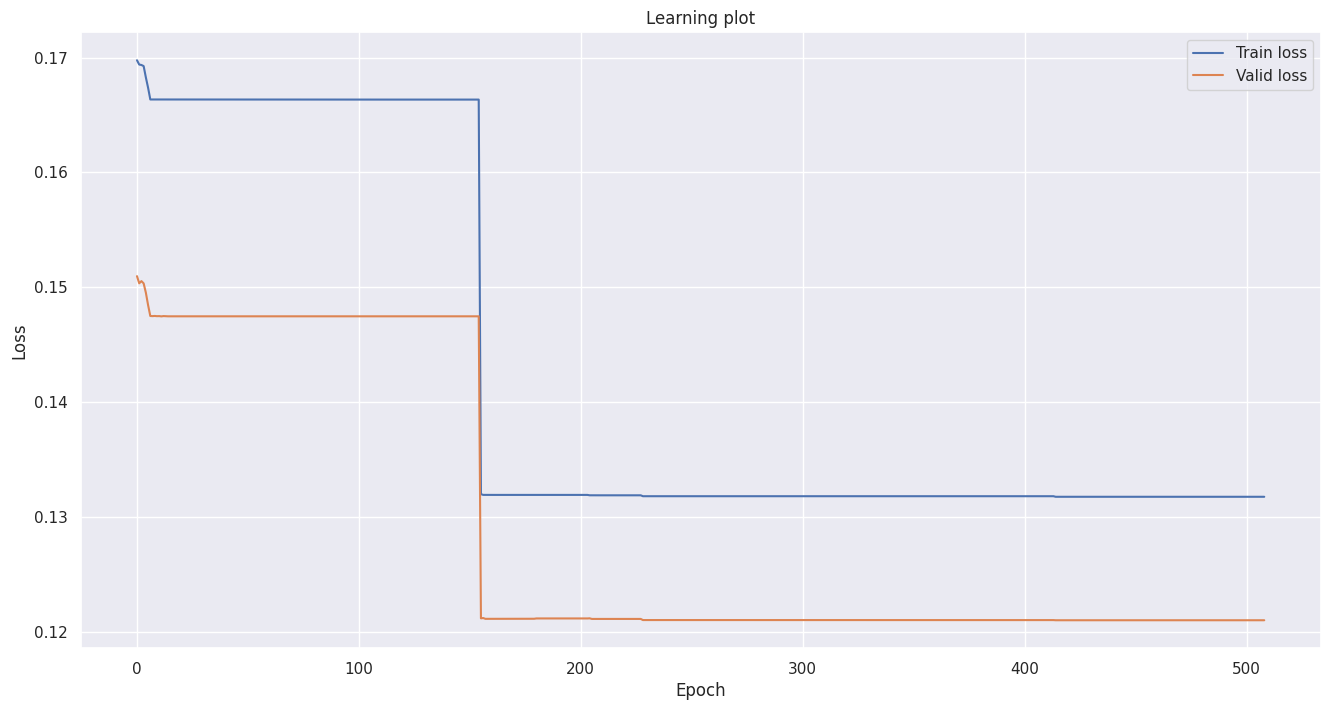

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
fit(model, train_loader, valid_loader, optimizer, 5000, 'Learning plot')

In [ ]:
wandb.finish()

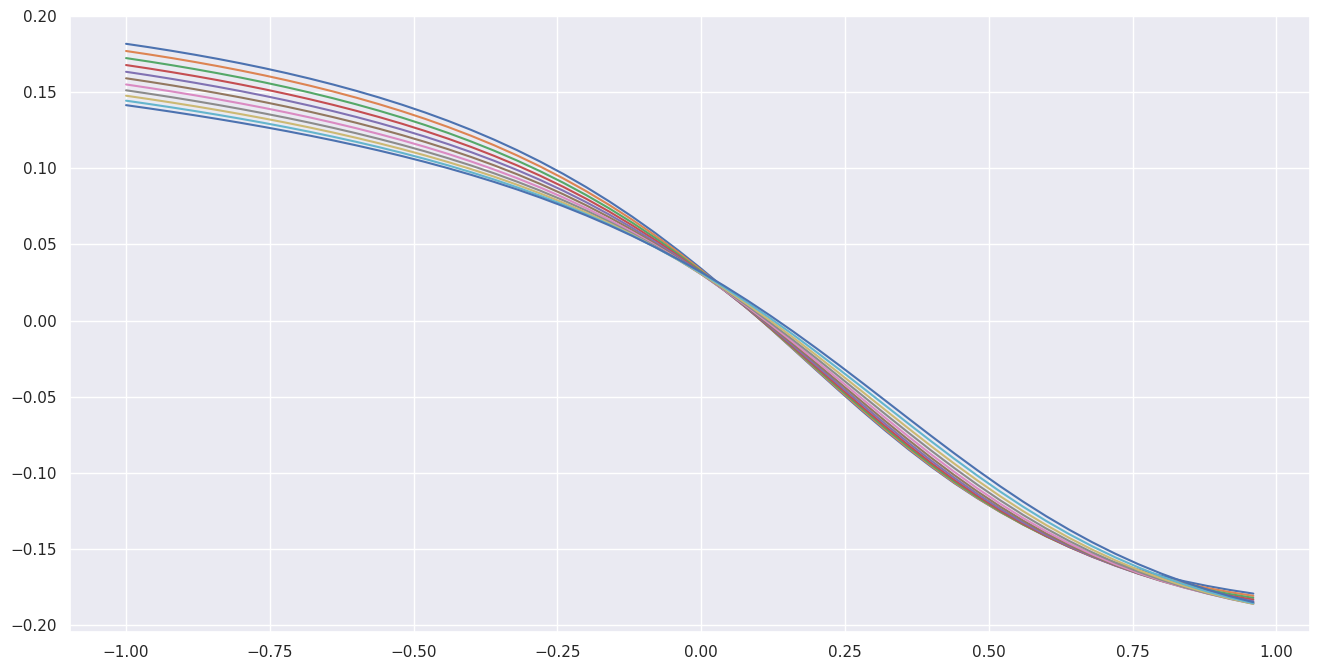

In [278]:
plt.figure(figsize=(16,8))
for it in range(11):
    T = 0.1 * it
    t, x, u = [], [], []
    for i in range(50):
        X = torch.Tensor([-1 + i * (2/50)])
        # print(X)
        t.append(torch.tensor([T]))
        x.append(X)
    
    t=torch.Tensor(t)
    x=torch.Tensor(x)
    
    pred = model(t.to(device), x.to(device)).cpu()
    # plt.xlim(-1,1)
    # plt.ylim(-1,1)
    plt.plot(x.detach().numpy(),pred.detach().numpy(), markersize=3)
# plt.savefig(f"./images/{it}.png")

In [ ]:
torch.save(model.state_dict(), "model.pth")

In [ ]:
import math
losses = []
for i in range(samples_cnt):
    x = -1 + i * (2/1000)
    losses.append(ls(model(torch.Tensor([0]), torch.Tensor([x])),torch.Tensor([-math.sin(math.pi * x)])))
sum(losses)/len(losses)

In [ ]:
list(torch.stack((t, x,u),axis=1))